# Introduction

This kernel is going to solve House Pricing with Advanced Regression Analysis, a machine learning dataset from Kaggle. It includes four steps: downloading data and creting validation datasets, EDA, data cleaning, fitting and validating linear regression models.


In [1]:
# Printing every output instead of just last one
from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# importing the packages
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import arrow
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris

In [3]:
# Figures inline and set visualization style
%matplotlib inline
sns.set()
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

---

## Downloading the Data, Creating Training and Validation data sets.

Data is downloaded from Kaggle. The data in train.csv is data that has values on the target variable. The data in test.csv is for generating predictions. 

To avoid accidantal data leakage, I'm splitting the data before doing EDA. “Hold out” cross-validation is used with a random split of the data into 80% training, 20% validation. The random number generator seed is set to a value, so that it would be possible to recreate the split if needed.

In [4]:
#Reading the data from the two csv files I downloaded from Kaggle.com
trainDat = pd.read_csv('train.csv')
testDat =  pd.read_csv('test.csv')

In [5]:
#checking the data
trainDat.shape
testDat.shape

(1460, 81)

(1459, 80)

In [6]:
# Checking that SalePrice is not in the test data (the variabble that we need to predict)
set(trainDat.columns).difference(set(testDat.columns))

{'SalePrice'}

In [7]:
# Checking that the features in the test data a subset of the train data features
set(testDat.columns).issubset(set(trainDat.columns))

True

### Spliting the Data for Hold Out Cross Validation

In [8]:
# Our "Y" variable
yDat = trainDat.SalePrice 
# Potential X's
XDat = trainDat.loc[:,trainDat.columns!='SalePrice']

In [9]:
# Random split using a scikit-learn preprocessing method
# seting the seed for the random generator so the results that we get can be reproduced
# shuffling the data before splitting

Xtrain, Xtest, ytrain, ytest = train_test_split( XDat, yDat, \
        train_size=0.8, random_state=9,                      \
         shuffle=True )

#checking the results
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((1168, 80), (292, 80), (1168,), (292,))

Xtrain and ytrain are to be used for model training.  xtest and ytest are to be used to validate the models, to find out how well they generalize the data they haven't "learned" from.

---

## EDA

- Using descriptive statistics and graphs to understand the distributions of the target variable and the features (all the other variables that might predict the target) in the training data, the random 80% data set you created. 
- Documenting the data types (categorical, ordered continuous, et.c) of the target and features. 
- Examining the target and features for problems like missing and incorrect (or suspicious) values, or that have limited or no variation.

In [10]:
# Data types of the potential features
Xtrain.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

In [11]:
# Data type of the target
ytrain.dtype

dtype('int64')

In [12]:
# taking a look at the train data
Xtrain.head()
ytrain.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1392,1393,85,RL,68.0,7838,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnWw,NaN,0,12,2006,WD,Normal
426,427,80,RL,NaN,12800,Pave,NaN,Reg,Low,AllPub,...,396,0,NaN,NaN,NaN,0,8,2009,WD,Normal
321,322,60,RL,99.0,12099,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal
425,426,60,RM,60.0,3378,Pave,Grvl,Reg,HLS,AllPub,...,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal
102,103,90,RL,64.0,7018,Pave,NaN,Reg,Bnk,AllPub,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Alloca


1392    123000
426     275000
321     354000
425     135000
102     118964
Name: SalePrice, dtype: int64

In [13]:
#checking the data types, missing values
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 1392 to 382
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    960 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          77 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  Overal

There seems to be several data types.

In [14]:
# summarizing the data
Xtrain.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1168.000000,1168.000000,960.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1161.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,731.872432,57.020548,70.161458,10259.947774,6.066781,5.587329,1970.083904,1984.011986,104.846684,439.532534,...,469.875856,91.159247,46.315068,22.773973,2.898116,16.046233,2.893836,48.830479,6.310788,2007.836473
std,422.892705,42.433793,24.603254,7184.387102,1.382592,1.118165,30.292742,20.785101,178.606890,461.118816,...,215.108241,122.201957,67.849259,62.066970,26.321831,57.489908,40.736249,548.916607,2.680691,1.336254
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,366.750000,20.000000,60.000000,7559.500000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,...,317.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,730.500000,50.000000,70.000000,9485.000000,6.000000,5.000000,1971.000000,1992.000000,0.000000,379.500000,...,477.500000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1099.250000,70.000000,80.000000,11604.000000,7.000000,6.000000,2000.000000,2003.000000,171.000000,697.250000,...,576.000000,165.250000,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1460.000000,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1418.000000,736.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [15]:
ytrain.describe()

count      1168.000000
mean     178753.636986
std       78296.025999
min       34900.000000
25%      129000.000000
50%      159697.500000
75%      212000.000000
max      745000.000000
Name: SalePrice, dtype: float64

The average sale price of a house is approx 180k, with most of the values falling within the 129k to 212k range.

In [16]:
Xtrain.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1168,1168,77,1168,1168,1168,1168,1168,1168,1168,...,1100,1100,1100,1100,1168,6,231,46,1168,1168
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,924,1165,41,753,1040,1167,842,1101,197,1012,...,689,495,1043,1055,1067,3,124,41,1015,955


### Checking for missing values

<AxesSubplot:>

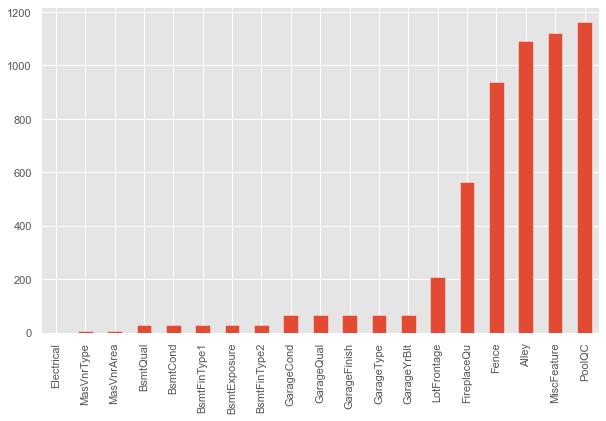

In [17]:
missing_data = Xtrain.isnull().sum()
missing_data = missing_data[missing_data>0]
missing_data.sort_values(inplace=True)
missing_data.plot.bar()

There are many columns have missing data. Let's take a look at the description of some of it:
PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None
Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
       
Looks like NaN in those categories means that a lot of the houses simply don't have those qualities, hence I'll remove them.

In [18]:
Xtrain.drop(['PoolQC','Fence','MiscFeature','Alley','FireplaceQu'],axis=1,inplace=True)

In [19]:
#Doing the same for test set:
Xtest.drop(['PoolQC','Fence','MiscFeature','Alley','FireplaceQu'],axis=1,inplace=True)

In [20]:
testDat.drop(['PoolQC','Fence','MiscFeature','Alley','FireplaceQu'],axis=1,inplace=True)

In [21]:
for col in Xtrain:
    if Xtrain[col].dtype == 'object':
        Xtrain[col] = Xtrain[col].fillna(Xtrain[col].mode()[0])
    else:
        Xtrain[col] = Xtrain[col].fillna(Xtrain[col].median())

In [22]:
#making sure there are no null values anymore
with pd.option_context('display.max_rows', None,):
   print(Xtrain.isnull().sum())

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

In [23]:
#Doing the same for test sets
for col in Xtest:
    if Xtest[col].dtype == 'object':
        Xtest[col] = Xtest[col].fillna(Xtest[col].mode()[0])
    else:
        Xtest[col] = Xtest[col].fillna(Xtest[col].median())

In [24]:
with pd.option_context('display.max_rows', None,):
   print(Xtest.isnull().sum())

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

In [25]:
for col in testDat:
    if testDat[col].dtype == 'object':
        testDat[col] = testDat[col].fillna(testDat[col].mode()[0])
    else:
        testDat[col] = testDat[col].fillna(testDat[col].median())

In [26]:
with pd.option_context('display.max_rows', None,):
   print(testDat.isnull().sum())

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

### Encoding Categorical Variables

In [27]:
print('Training Features shape: ', Xtrain.shape)
print('Testing Features shape: ', Xtest.shape)
print('Testing Features shape: ', testDat.shape)

Training Features shape:  (1168, 75)
Testing Features shape:  (292, 75)
Testing Features shape:  (1459, 75)


In [28]:
Xtrain.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          7
Exterior1st      14
Exterior2nd      14
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

Using LabelEncoder for features with only 2 categories:

In [29]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in Xtrain:
    if Xtrain[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(Xtrain[col].unique())) <= 2:
            # Train on the training data
            le.fit(Xtrain[col])
            # Transform both training and testing data
            Xtrain[col] = le.transform(Xtrain[col])
            Xtest[col] = le.transform(Xtest[col])
            testDat[col] = le.transform(testDat[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

LabelEncoder()

LabelEncoder()

LabelEncoder()

3 columns were label encoded.


Using hot encoding for all other categorical features.

In [30]:
# one-hot encoding of categorical variables
Xtrain = pd.get_dummies(Xtrain)
Xtest = pd.get_dummies(Xtest)
testDat = pd.get_dummies(testDat)

print('Training Features shape: ', Xtrain.shape)
print('Testing Features shape: ', Xtest.shape)
print('Testing Features shape: ', testDat.shape)

Training Features shape:  (1168, 264)
Testing Features shape:  (292, 238)
Testing Features shape:  (1459, 253)


Let's drop the extra columns.

In [31]:
columns=testDat.columns

In [32]:
set(Xtrain.columns).difference(set(testDat.columns))

{'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'Electrical_Mix',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'GarageQual_Ex',
 'Heating_Floor',
 'Heating_OthW',
 'HouseStyle_2.5Fin',
 'RoofMatl_ClyTile',
 'RoofMatl_Metal',
 'RoofMatl_Roll'}

In [33]:
Xtrain.drop(['Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'Electrical_Mix',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'GarageQual_Ex',
 'Heating_Floor',
 'Heating_OthW',
 'HouseStyle_2.5Fin',
 'RoofMatl_ClyTile',
 'RoofMatl_Metal',
 'RoofMatl_Roll'],axis=1,inplace=True)

In [34]:
set(testDat.columns).difference(set(Xtrain.columns))

{'Exterior1st_CBlock', 'Exterior2nd_CBlock'}

In [35]:
testDat.drop(['Exterior1st_CBlock', 'Exterior2nd_CBlock'],axis=1,inplace=True)

In [36]:
set(testDat.columns).difference(set(Xtest.columns))

{'BsmtCond_Po',
 'Condition1_RRNn',
 'Condition2_Artery',
 'Condition2_PosA',
 'Condition2_PosN',
 'ExterCond_Po',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior2nd_AsphShn',
 'Functional_Maj2',
 'Functional_Sev',
 'GarageCond_Ex',
 'GarageType_2Types',
 'HeatingQC_Po',
 'Neighborhood_Blueste',
 'RoofStyle_Shed',
 'SaleCondition_Alloca',
 'SaleType_CWD',
 'SaleType_ConLI',
 'SaleType_Oth'}

### Back to EDA

Now let's look at the distribution of the Sale Price.

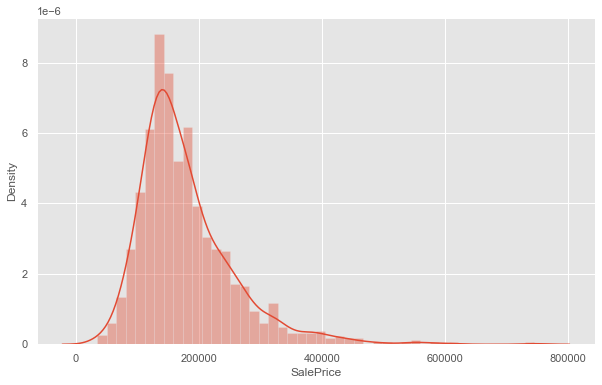

In [37]:
#Looking at the distribution of the target variable
ax = sns.distplot(ytrain)
plt.show()

In [38]:
ytrain.describe()

count      1168.000000
mean     178753.636986
std       78296.025999
min       34900.000000
25%      129000.000000
50%      159697.500000
75%      212000.000000
max      745000.000000
Name: SalePrice, dtype: float64

As we can see from the visualisations above, the target variable is right skewed. 

**I will log transform this data to make it as “normal” as possible so that the statistical analysis results from this data become more valid.**

In [39]:
#y_train = np.log(ytrain)

#ax = sns.distplot(y_train)
#plt.show()

In [40]:
#y_train

In [41]:
X_train = (Xtrain - Xtrain.mean())/Xtrain.std()
X_test = (Xtest - Xtest.mean())/Xtest.std()

In [42]:
X_train
Xtrain

,Id,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1392,1.563346,0.659367,-0.095623,-0.337113,0.050724,-0.02926,-0.771580,-0.525261,-0.101803,-0.818470,...,-0.041398,-0.300819,-0.050724,0.388085,-0.285327,-0.02926,-0.101842,-0.106046,0.472065,-0.304188
426,-0.720921,0.541537,-0.005950,0.353552,0.050724,-0.02926,0.674978,-0.525261,0.624443,0.239980,...,-0.041398,-0.300819,-0.050724,0.388085,-0.285327,-0.02926,-0.101842,-0.106046,0.472065,-0.304188
321,-0.969211,0.070214,1.294309,0.255979,0.050724,-0.02926,1.398257,-0.525261,1.119611,0.961651,...,-0.041398,-0.300819,-0.050724,0.388085,-0.285327,-0.02926,-0.101842,-0.106046,0.472065,-0.304188
425,-0.723286,0.070214,-0.454315,-0.957903,0.050724,-0.02926,0.674978,2.157705,-0.795039,0.384314,...,-0.041398,-0.300819,-0.050724,0.388085,-0.285327,-0.02926,-0.101842,-0.106046,0.472065,-0.304188
102,-1.487073,0.777198,-0.274969,-0.451249,0.050724,-0.02926,-0.771580,-0.525261,0.294331,-0.241134,...,-0.041398,-0.300819,-0.050724,0.388085,-0.285327,-0.02926,9.810752,-0.106046,-2.116537,-0.304188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,-1.595848,2.426826,-2.068430,-1.059930,0.050724,-0.02926,1.398257,-0.525261,0.954555,0.769205,...,-0.041398,-0.300819,-0.050724,0.388085,3.501745,-0.02926,-0.101842,-0.106046,-2.116537,-0.304188
501,-0.543572,0.070214,0.218233,-0.063603,0.050724,-0.02926,0.674978,-0.525261,1.152623,1.009762,...,-0.041398,-0.300819,-0.050724,0.388085,-0.285327,-0.02926,-0.101842,-0.106046,0.472065,-0.304188
638,-0.219612,-0.636770,-0.140460,-0.206413,0.050724,-0.02926,-0.771580,1.263383,-1.983442,-1.636364,...,-0.041398,-0.300819,-0.050724,0.388085,-0.285327,-0.02926,-0.101842,-0.106046,0.472065,-0.304188
348,-0.905365,2.426826,-1.530392,-1.087351,0.050724,-0.02926,0.674978,-0.525261,1.086600,0.961651,...,-0.041398,-0.300819,-0.050724,0.388085,-0.285327,-0.02926,-0.101842,-0.106046,0.472065,-0.304188


,Id,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1392,1393,85,68.0,7838,1,0,5,5,1967,1967,...,0,0,0,1,0,0,0,0,1,0
426,427,80,70.0,12800,1,0,7,5,1989,1989,...,0,0,0,1,0,0,0,0,1,0
321,322,60,99.0,12099,1,0,8,5,2004,2004,...,0,0,0,1,0,0,0,0,1,0
425,426,60,60.0,3378,1,0,7,8,1946,1992,...,0,0,0,1,0,0,0,0,1,0
102,103,90,64.0,7018,1,0,5,5,1979,1979,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,57,160,24.0,2645,1,0,8,5,1999,2000,...,0,0,0,1,1,0,0,0,0,0
501,502,60,75.0,9803,1,0,7,5,2005,2005,...,0,0,0,1,0,0,0,0,1,0
638,639,30,67.0,8777,1,0,5,7,1910,1950,...,0,0,0,1,0,0,0,0,1,0
348,349,160,36.0,2448,1,0,7,5,2003,2004,...,0,0,0,1,0,0,0,0,1,0


In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(Xtrain)

train_sample = scaler.transform(Xtrain)
test_sample = scaler.transform(Xtest)

StandardScaler()

ValueError: X has 238 features, but StandardScaler is expecting 251 features as input.

### Looking for correlations

In [44]:
mergedxy=Xtrain.join(ytrain)

In [45]:
#looking for correlations
correlations = mergedxy.corr()
correlations = correlations.sort_values('SalePrice')
cols = correlations['SalePrice'][correlations['SalePrice'].values > 0.2].index.values

In [46]:
cols

array(['GarageType_Attchd', 'BsmtFullBath', 'LotShape_IR1', 'BsmtUnfSF',
       'Neighborhood_StoneBr', 'PavedDrive_Y', 'HouseStyle_2Story',
       'Electrical_SBrkr', 'BsmtQual_Gd', 'MSZoning_RL', 'CentralAir',
       'RoofStyle_Hip', 'GarageType_BuiltIn', 'BsmtExposure_Gd',
       'LotArea', 'HalfBath', 'Neighborhood_NoRidge', 'WoodDeckSF',
       '2ndFlrSF', 'Exterior1st_VinylSd', 'OpenPorchSF',
       'Exterior2nd_VinylSd', 'LotFrontage', 'KitchenQual_Gd',
       'MasVnrType_Stone', 'BsmtFinSF1', 'SaleCondition_Partial',
       'SaleType_New', 'GarageFinish_Fin', 'Neighborhood_NridgHt',
       'BsmtFinType1_GLQ', 'HeatingQC_Ex', 'Fireplaces', 'ExterQual_Ex',
       'MasVnrArea', 'ExterQual_Gd', 'GarageYrBlt', 'KitchenQual_Ex',
       'YearRemodAdd', 'Foundation_PConc', 'TotRmsAbvGrd', 'BsmtQual_Ex',
       'YearBuilt', 'FullBath', '1stFlrSF', 'TotalBsmtSF', 'GarageArea',
       'GarageCars', 'GrLivArea', 'OverallQual', 'SalePrice'],
      dtype=object)

In [47]:
cols=cols[:-1]

<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

Index(['ExterQual_TA', 'KitchenQual_TA', 'GarageFinish_Unf', 'BsmtQual_TA',
       'YearRemodAdd', 'Foundation_PConc', 'TotRmsAbvGrd', 'BsmtQual_Ex',
       'YearBuilt', 'FullBath', '1stFlrSF', 'TotalBsmtSF', 'GarageArea',
       'GarageCars', 'GrLivArea', 'OverallQual', 'SalePrice'],
      dtype='object')

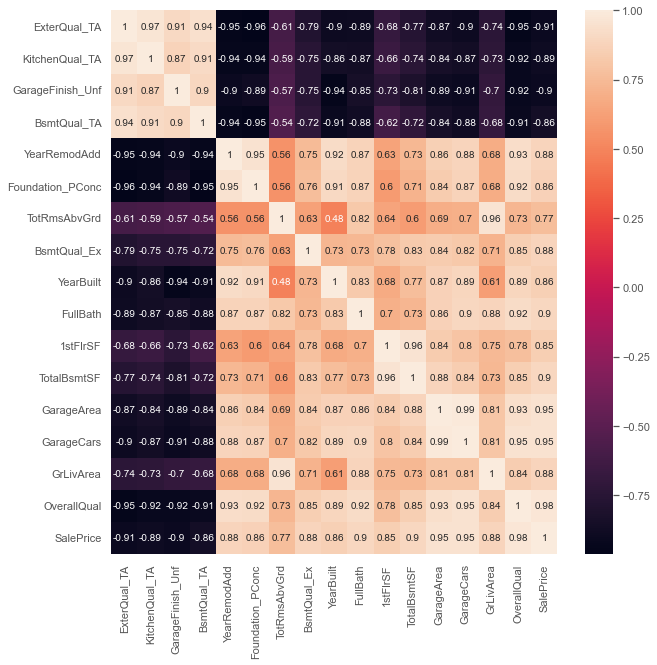

In [49]:
top_corr_features = correlations.index[abs(correlations['SalePrice'])>0.5]
plt.figure(figsize=(10,10))
sns.heatmap(correlations[top_corr_features].corr(),annot = True);
top_corr_features

In [50]:
ytrain = mergedxy['SalePrice']

Xtrain = mergedxy[cols]

Xtest = Xtest[cols]

testDat = testDat[cols]

In [51]:
print('Training Features shape: ', Xtrain.shape)
print('Testing Features shape: ', Xtest.shape)
print('Testing Features shape: ', testDat.shape)

Training Features shape:  (1168, 50)
Testing Features shape:  (292, 50)
Testing Features shape:  (1459, 50)


---
## Fitting and Validating Linear Regression Models that predict “SalePrice”


In [54]:
linReg = linear_model.LinearRegression(n_jobs=-1)  # an instance of the method
# Ordinary least squares Linear Regression. n_jobs - The number of jobs to use for the computation

This regression method wants numpy arrays as input data.

In [55]:
# Make some numpy arrays
X=Xtrain.to_numpy(copy=True)
y=ytrain.to_numpy(copy=True)
Xt=Xtest.to_numpy(copy=True)
yt=ytest.to_numpy(copy=True)
# What does copy do? - making sure returned value is not a view

## Baseline Model Training and Validating - Linear Regression

In [56]:
# Baseline model training
reg0=linReg.fit(X,y)

### Fit Measures
We will evaluate the performance of the models using two metrics - R-squared value and Root Mean Squared Error (RMSE).
R-squared values range from 0 to 1 and are commonly stated as percentages. It is a statistical measure that represents the proportion of the variance for a target variable that is explained by the independent variables. The other commonly used metric for regression problems is RMSE, that measures the average magnitude of the residuals or error. We will be using both these metrics to evaluate the model performance.

In [57]:
print('Coefficient of Determination')
R2Train=reg0.score(X,y).round(3)
print(f'Training R2: {R2Train}')
testPred=linReg.predict(Xt)
R2Test=metrics.r2_score(yt,testPred).round(3)
print(f'Test R2: {R2Test}')

Coefficient of Determination
Training R2: 0.844
Test R2: 0.861


### MSE


In [58]:
trainPred=reg0.predict(X)
trainMSE=metrics.mean_squared_error(y,trainPred)
testMSE=metrics.mean_squared_error(yt,testPred)
trainRMSE=math.sqrt(trainMSE)
testRMSE=math.sqrt(testMSE)
print(f'training RMSE: {round(trainRMSE,2)}')
print(f'test RMSE: {round(testRMSE,2)}')

training RMSE: 30939.05
test RMSE: 31033.38


In [59]:
#preparing the test data 
tD=testDat.to_numpy(copy=True)

In [60]:
testPred=reg0.predict(tD)

In [61]:
#saving to file
pred=pd.DataFrame(testPred)
sub_df=pd.read_csv('sample_submission.csv')
datasets=pd.concat([sub_df['Id'],pred],axis=1)
datasets.columns=['Id','SalePrice']
datasets.to_csv('sample_submission.csv',index=False)

Kaggle result: 0.16222